# Gene Expression Monitoring Analysis

## Data Preparation

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Let's start by taking a look at our target, the ALL/AML label.

In [2]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('../input/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In the combined training and testing sets there are 72 patients, each of whom are labelled either "ALL" or "AML" depending on the type of leukemia they have. Here's the breakdown:

In [3]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

We actually need our labels to be numeric, so let's just do that now.

In [4]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

Now we move on to the features, which are provided for the training and testing datasets separately.

In [5]:
# Import training data
df_train = pd.read_csv('../input/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('../input/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [6]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [7]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,48,call.4,49,call.5,41,call.6,43,call.7,44,call.8,45,call.9,46,call.10,70,call.11,71,call.12,72,call.13,68,call.14,69,call.15,67,call.16,55,call.17,56,call.18,59,call.19,52,call.20,53,call.21,51,call.22,50,call.23,54,call.24,57,call.25,58,call.26,60,call.27,61,call.28,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,-130,A,-256,A,-62,A,86,A,-146,A,-187,A,-56,A,-55,A,-59,A,-131,A,-154,A,-79,A,-76,A,-34,A,-95,A,-12,A,-21,A,-202,A,-112,A,-118,A,-90,A,-137,A,-157,A,-172,A,-47,A,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,-177,A,-249,A,-23,A,-36,A,-74,A,-187,A,-43,A,-44,A,-114,A,-126,A,-136,A,-118,A,-98,A,-144,A,-118,A,-172,A,-13,A,-274,A,-185,A,-142,A,-87,A,-51,A,-370,A,-122,A,-442,A,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,-28,A,-410,A,-7,A,-141,A,170,A,312,A,43,A,12,A,23,A,-50,A,49,A,-30,A,-153,A,-17,A,59,A,12,A,8,A,59,A,24,A,212,A,102,A,-82,A,-77,A,38,A,-21,A,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,266,A,24,A,142,A,252,A,174,A,142,A,177,A,129,A,146,A,211,A,180,A,68,A,237,A,152,A,270,A,172,A,38,A,309,A,170,A,314,A,319,P,178,A,340,A,31,A,396,A,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,-170,A,-535,A,-233,A,-201,A,-32,A,114,A,-116,A,-108,A,-171,A,-206,A,-257,A,-110,A,-215,A,-174,A,-229,A,-137,A,-128,A,-456,A,-197,A,-401,A,-283,A,-135,A,-438,A,-201,A,-351,A,-256,A,-191,A,-172,A,-496,A,-294,A


In [8]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [9]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [10]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.

In [11]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),AFFX-BioB-M_st (endogenous control),AFFX-BioB-3_st (endogenous control),AFFX-BioC-5_st (endogenous control),AFFX-BioC-3_st (endogenous control),AFFX-BioDn-5_st (endogenous control),AFFX-BioDn-3_st (endogenous control),AFFX-CreX-5_st (endogenous control),AFFX-CreX-3_st (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-5_at (endogenous control),AFFX-DapX-M_at (endogenous control),AFFX-DapX-3_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-LysX-M_at (endogenous control),AFFX-LysX-3_at (endogenous control),AFFX-PheX-5_at (endogenous control),AFFX-PheX-M_at (endogenous control),AFFX-PheX-3_at (endogenous control),AFFX-ThrX-5_at (endogenous control),AFFX-ThrX-M_at (endogenous control),AFFX-ThrX-3_at (endogenous control),AFFX-TrpnX-5_at (endogenous control),AFFX-TrpnX-M_at (endogenous control),AFFX-TrpnX-3_at (endogenous control),AFFX-HUMISGF3A/M97935_5_at (endogenous control),AFFX-HUMISGF3A/M97935_MA_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),...,GB DEF = SPR2-1 gene for small proline rich pr...,Metallothionein,GB DEF = Glutamate dehydrogenase,PRSS3 Protease; serine; 3 (trypsin 3),GB DEF = Transmembrane protein Tmp21-IIex,GB DEF = H2B/h gene,ACTB Actin; beta,GAPD Glyceraldehyde-3-phosphate dehydrogenase,CYTOCHROME P450 IA2,Nkat2b mRNA,Natural killer cell receptor (KIR) mRNA,Major Histocompatibility Complex; Class I; C (...,HLA-A MHC class I protein HLA-A (HLA-A28;-B40;...,PRB2 locus salivary proline-rich protein mRNA;...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1...,GB DEF = (HLCC85) mRNA for voltage-dependent L...,GB DEF = Endogenous retrovirus clone P1.8 poly...,Integrase gene extracted from Human endogenous...,WUGSC:GS345D13.2 gene (G-protein gamma-1 subun...,TIAL1 TIA1 cytotoxic granule-associated RNA-bi...,Ras-Specific Guanine Nucleotide-Releasing Factor,TYROSINE-PROTEIN KINASE ITK/TSK,(clone p4) 50 kD dystrophin-associated glycopr...,Ifp35 gene extracted from Human BRCA1; Rho7 an...,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgra...,PLGL Plasminogen-like protein,ID1 Inhibitor of DNA binding 1; dominant negat...,ABP1 Amiloride binding protein 1 (amine oxidas...,Transcriptional activator hSNF2b,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-

This is still messy as the first two rows are more or less duplicates of one another and we haven't yet created the column names. Let's simply turn the second row into the column names and delete the first row.

In [12]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


In [13]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

Let's now take a look at some summary statistics:

In [14]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,67.947368,-701.105263,-492.868421,-194.394737,110.263158,189.894737,-70.868421,-342.105263,20276.657895,29.210526,170.315789,-95.421053,19.131579,-151.763158,89.631579,-91.631579,-134.157895,-7.368421,-21.184211,-48.447368,-278.342105,7.184211,-550.710526,-245.447368,-206.921053,-2.026316,214.236842,765.263158,4133.368421,2576.315789,...,268.815789,-365.921053,271.210526,483.078947,396.631579,463.342105,17991.447368,16025.789474,819.473684,292.868421,171.894737,10554.526316,9033.710526,396.921053,2495.921053,-230.894737,10.763158,319.105263,-9.105263,222.815789,53.421053,73.368421,-21.368421,266.789474,128.842105,220.105263,334.605263,-273.684211,-1678.842105,965.263158,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,168.362535,235.446647,219.930231,124.907001,136.108995,132.304683,70.325179,193.686957,7546.053808,81.206829,101.666946,60.176152,38.604839,108.490237,80.849684,45.844285,57.983468,65.672990,51.336124,38.629003,115.244576,54.755405,156.187155,68.982841,135.338890,439.362037,315.278636,737.537381,5690.572471,4141.001342,...,99.401413,657.032369,228.186168,1462.672459,161.848515,469.653022,5782.493541,3883.585841,530.540303,159.607317,248.903410,3581.291657,3982.630931,321.125502,1986.098340,95.769653,66.839636,188.752775,52.387222,111.896394,46.237712,62.082082,201.001737,128.158719,124.958485,92.496542,172.760503,166.168281,929.175064,754.069489,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,-209.000000,-1250.000000,-962.000000,-541.000000,-96.000000,-156.000000,-179.000000,-874.000000,6479.000000,-126.000000,-39.0

Clearly there is some variation in the scales across the different features. Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [15]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

With 7129 features, it's also worth considering whether we might be able to reduce the dimensionality of the dataset. Once very common approach to this is principal components analysis (PCA). Let's start by leaving the number of desired components as an open question: 

In [16]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

Let's set a threshold for explained variance of 90% and see how many features are required to meet that threshold. (Here we are using the code from [this kernel](https://www.kaggle.com/rstogi896/geneclassification-using-gridsearchcv-and-svm).) 

22 features explain around 90% of the variance. From 7129 features to 22, not too bad.


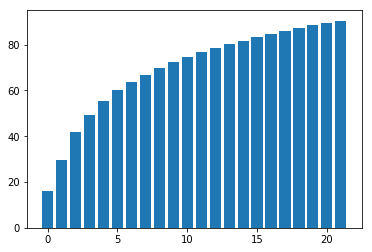

In [17]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

We can't plot something in 22 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments. (Here we are using code taken from [this kernel](https://www.kaggle.com/kanav0183/pca-analysis-for-geneclassification).)  

[]

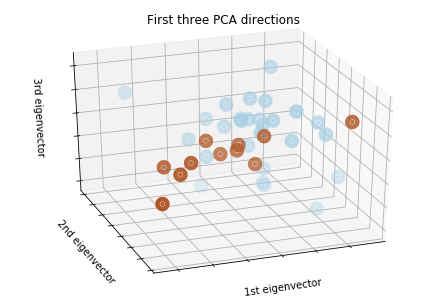

In [18]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

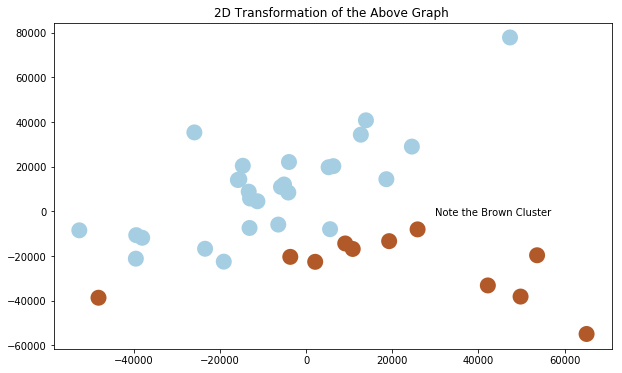

In [19]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

## Model Building

Having prepared the dataset, it's now finally time to try out some models. 

### Baseline

In [20]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


### K-Means Clustering

First we shall try an unsupervised clustering approach using the scaled data.

K-means accuracy: 0.765


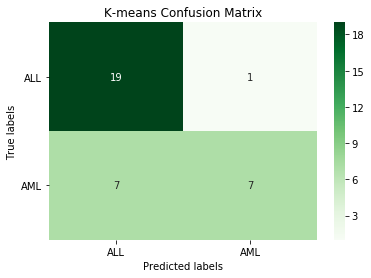

In [21]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

This K-means approach is better than the baseline, but we should be able to do better with some kind of supervised learning model.

### Naive Bayes

For our first supervised model, we shall use a very straightforward naive bayes approach.

Naive Bayes accuracy: 0.912


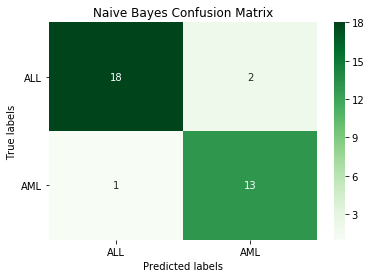

In [22]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

The naive bayes model is pretty good, just three incorrect classifications.

### Logistic Regression

Another very standard approach is logistic regression. Here we will be using grid search cross-validation tuning to try and determine the best hyperparameters. We don't need to scale the data for logistic regression, nor are we using the PCA version of the dataset. 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


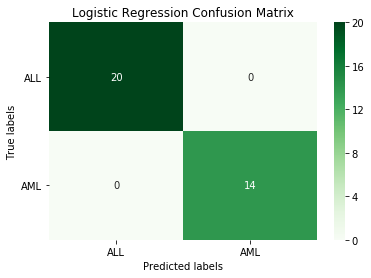

In [23]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

This logistic regression model manages perfect classification.

### Support Vector Machine

Here we will try another traditional approach, a support vector machine (SVM) classifier. For the SVM, so we using the PCA version of the dataset. Again we use grid search cross-validation to tune the model.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941


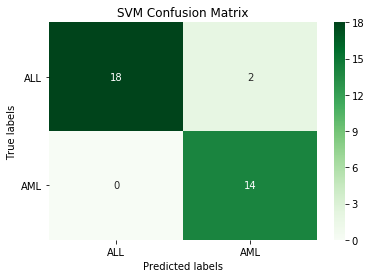

In [24]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

This SVM model is making just a couple of classification errors.

### Random Forest

We now move on to tree-base approaches, starting with the very popular random forest. We don't need scaled data for this, so again we wont use the scaled version of the dataset, just a grid search for tuning the hyperparameters.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


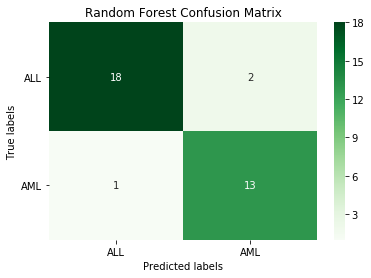

In [25]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Random forest almost matches the SVM performance.

### XG Boost

Nowadays, gradient boosting models such as XG Boost(XGB) are extremely popular. Here we shall experiment with three alternative versions, PCA with grid search, PCA without grid search and also the orginal data without either PCA or grid search.

#### XGB — PCA with Grid Search

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 130}
XGB (PCA with Grid Search) accuracy: 0.794


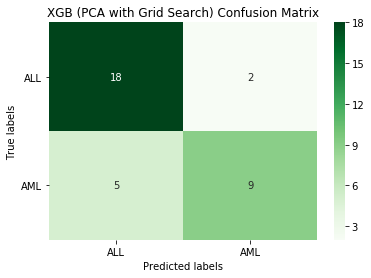

In [26]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

fixed_params = {'random_state': 0,
                'n_jobs': -1}

xgb_model = GridSearchCV(xgb.XGBClassifier(**fixed_params), 
                       param_grid = xgb_grid_params, 
                       scoring = 'accuracy',
                       cv = 3)

xgb_model.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", xgb_model.best_params_)

# Get the best model
xgb_model_best = xgb_model.best_estimator_

# Make predictions using the optimised parameters
xgb_pred = xgb_model_best.predict(X_test_pca)

print('XGB (PCA with Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb_pred), 3))

cm_xgb = confusion_matrix(y_test.iloc[:,1], xgb_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA with Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

XGB with PCA and grid search isn't particularly good.

#### XGB — PCA with no Grid Search

Accuracy:  0.824


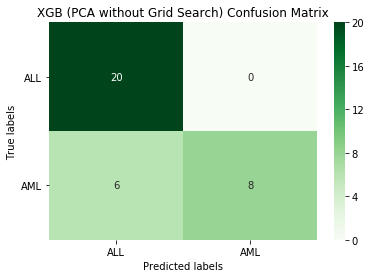

In [27]:
xgb2_model = xgb.XGBClassifier()
xgb2_model.fit(X_train_pca, y_train.iloc[:,1])

xgb2_pred = xgb2_model.predict(X_test_pca)

print('Accuracy: ', round(accuracy_score(y_test.iloc[:,1], xgb2_pred), 3))

cm_xgb2 = confusion_matrix(y_test.iloc[:,1], xgb2_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb2, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA without Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Without the grid search, this is barely any better. However, it seems that the grid search may possibly be resulting in some overfitting.

#### XGB — no PCA or Grid Search

XGB (no PCA or Grid Search) accuracy: 0.912


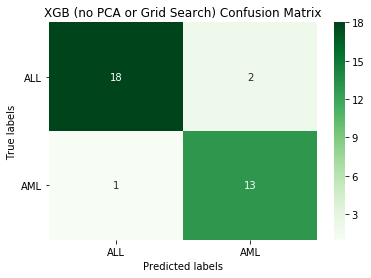

In [28]:
xgb3_model = xgb.XGBClassifier()
xgb3_model.fit(X_train, y_train.iloc[:,1])

xgb3_pred = xgb3_model.predict(X_test)

print('XGB (no PCA or Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb3_pred), 3))

cm_xgb3 = confusion_matrix(y_test.iloc[:,1], xgb3_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb3, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (no PCA or Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

OK, that's more like it. It seems that the PCA was actually the wrong approach for the XGB model.

### Neural Network

Finally we shall build a neural network using Keras (with TensorFlow as a backend). This only a "shallow" learning model with one hidden layer — adding several extra layers with so few training datapoints would just lead to overfitting.  

In [29]:
# Create model architecture
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7129,)))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [31]:
# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

In [32]:
# Set up early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(partial_X_train,
            partial_y_train,
            epochs=50,
            batch_size=4,
            validation_data=(X_val, y_val),
            callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 8 samples
Epoch 1/50
30/30 [==============================] - 0s 15ms/step - loss: 0.3482 - acc: 0.8333 - val_loss: 0.1423 - val_acc: 1.0000
Epoch 2/50
30/30 [==============================] - 0s 960us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.2331 - val_acc: 0.8750
Epoch 3/50
30/30 [==============================] - 0s 987us/step - loss: 8.0930e-04 - acc: 1.0000 - val_loss: 0.2614 - val_acc: 0.8750
Epoch 4/50
30/30 [==============================] - 0s 954us/step - loss: 2.3850e-04 - acc: 1.0000 - val_loss: 0.2747 - val_acc: 0.8750
Epoch 00004: early stopping


Neural Network accuracy:  0.765


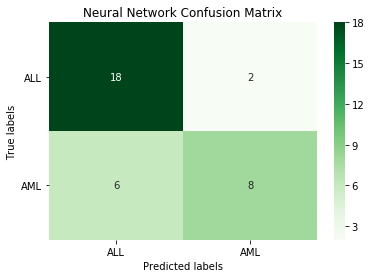

In [33]:
# Make predictions
nn_pred = model.predict_classes(X_test_scl)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 3))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

The neural network isn't as good as some of the other models.